## Проект: Выбираем авто выгодно

Задача проекта: создать модель, которая будет предсказывать цену автомобиля на вторичном рынке.

In [3]:
#Необходимые библиотеки
import pandas as pd
from pandas import Series
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from catboost import CatBoostRegressor
from sklearn import metrics
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.filterwarnings("ignore")
import category_encoders as ce
import datetime
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LinearRegression

Тренировочные данные были собраны с сайта auto.ru

In [107]:
#Загружаем датасеты
train = pd.read_csv('data_train_final.csv')
test = pd.read_csv('test_6.csv')


In [109]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [5]:
#train.reg.fillna(1, inplace=True)

In [6]:
#train.reg.value_counts()

In [7]:
train = train[['color', 'car_price', 'mileage', 'productionDate', 'brand',
             'model_name', 'bodyType', 'engineDisplacement', 'enginePower',
             'fuelType', 'sell_id', 'vehicleTransmission', 'Владельцы',
             'ПТС', 'Привод', 'Руль', 'Состояние']]

In [8]:
#Посмотрим, что из себя представляют полученные данные
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77529 entries, 0 to 77528
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   color                77529 non-null  object 
 1   car_price            77529 non-null  int64  
 2   mileage              77529 non-null  int64  
 3   productionDate       77529 non-null  int64  
 4   brand                77529 non-null  object 
 5   model_name           77529 non-null  object 
 6   bodyType             77529 non-null  object 
 7   engineDisplacement   77529 non-null  object 
 8   enginePower          77529 non-null  int64  
 9   fuelType             77529 non-null  object 
 10  sell_id              77529 non-null  float64
 11  vehicleTransmission  77529 non-null  object 
 12  Владельцы            77529 non-null  object 
 13  ПТС                  77529 non-null  object 
 14  Привод               77529 non-null  object 
 15  Руль                 77529 non-null 

In [9]:
#test['reg'] = 1

In [10]:
#Тестовая выборка
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

Данные, полученные в результате парсинга, необходимо обработать:
- Присутсвуют пропуски в данных
- Также стоит обратить внимание на формат данных: переменные в тренировочном датасете, которые должны иметь численный вид, находятся в формате object.
- Привести к общему виду тренировочную и тестовые выборки

In [11]:
#Проверим когда собиралась тестовая выборка
test.parsing_unixtime.apply(lambda s: datetime.datetime.fromtimestamp(s).strftime('%Y-%m')).unique()

array(['2020-10'], dtype=object)

Данные тренировочной выборки собирались в октябре 2020 года

In [13]:
'''Предобработка'''
#для воспроизводимости фиксируем RANDOM_SEED
RANDOM_SEED = 42

VAL_SIZE = 0.2

#Считаем МАРЕ
def mape(Y_true, Y_predicted):
    mape = np.mean(np.abs((Y_true-Y_predicted)/Y_true))*100
    return mape

#Обработка цветов автомобилей
dark_colors = ['серый', 'серебристый', 'коричневый']
def get_color(color):
    if color in dark_colors:
        return 'dark'
    elif color == 'белый':
        return 'white'
    elif color == 'чёрный':
        return 'black'
    else:
        return 'bright'
    
#Функция для анализа выбросов
def get_quantile(df, column):
    #вычисляем межквартильный размах:
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    #25-й перцентиль:
    perc25 = df[column].quantile(0.25)
    #75-й перцентиль:
    perc75 = df[column].quantile(0.75)

    #верхняя граница выбросов:
    l = perc75 + 1.5*iqr
    #нижняя граница выбросов:
    f = perc25 - 1.5*iqr
    
    #считаем количество выбросов
    print('Количество выбросов:', column, ':',
         df[df[column]<(perc25-1.5*iqr)][column].count() +
          df[df[column]>(perc75+1.5*iqr)][column].count())
    
    print('Верхняя граница выбросов:',
          l, 'Нижняя граница выбросов:', f)

    #всё что выпадает за границы выбросов, заменяем на граничное значение
    df[column] = df[column].apply(lambda m: f if m < f else m)
    df[column] = df[column].apply(lambda m: l if m > l else m)

#Текущий год
now = datetime.datetime.now()
year = now.year

#Классифицируем автомобили по возрасту
def get_class(p_year):
    if p_year < 1985:
        return 'oldtimer'
    #if 1970 < p_year < 1990:
        #return 'youngtimer'
    else:
        return 'used'

#Построим box-plot для числовых признаков    
def get_boxplot(
    data: pd.DataFrame, 
    column: str, 
    target_column: str
):
   
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=target_column, 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Боксплот: ' + column)
    plt.show()
    
#Обработка типов кузова
def get_types(type):
    if type in ['кабриолет', 'купе', 'купе-хардтоп', 'родстер', 'тарга', 'фастбек']:
        return 'gt'
    if type in ['компактвэн', 'микровэн', 'минивэн']:
        return 'van'
    if type == 'универсал':
        return 'family'
    if type == 'внедорожник':
        return 'suv'
    if type in ['седан', 'седан-хардтоп']:
        return 'sedan'
    if type in ['хэтчбек', 'лифтбек']:
        return 'hatch'
    if type in ['пикап', 'фургон']:
        return 'truck'
    if type == 'лимузин':
        return 'premium'
    else:
        return type
    
#Рейтинг надёжности
rating_list = {'toyota' : 98,
               'volkswagen' : 163,
               'nissan' : 128,
               'bmw' : 108,
               'mercedes' : 122,
               'audi' : 127,
               'mitsubishi' : 116,
               'skoda' : 163,
               'honda' : 145,
               'volvo' : 143,
               'lexus' : 81,
               'infiniti' : 137}

#Тип топлива    
def fuel_type(s):
    if 'бензин' in s:
        return 'бензин'
    if 'дизель' in s:
        return 'дизель'
    if 'гибрид' in s:
        return 'гибрид'
    if 'газ' in s:
        return 'газ'
    else:
        return 'электро'
    
#Расходы на содержание автомобиля
car_expences_list = {'bmw':106800,
                     'mercedes':77400,
                     'volvo':75000,
                     'audi':74400,
                     'infiniti':55800,
                     'volkswagen':56160,
                     'skoda':56160,
                     'nissan':54720,
                     'mitsubishi':53280,
                     'honda':51840,
                     'lexus':50400,
                     'toyota':39600}
    

Приведём тестовую и обучающие выборки к общему виду, для этого удалим лишние колонки из тестовой выборки

In [14]:
test.drop(['car_url', 'complectation_dict', 'description', 'equipment_dict',
          'image', 'modelDate', 'model_info', 'name', 'numberOfDoors', 'parsing_unixtime',
          'priceCurrency', 'super_gen', 'vehicleConfiguration', 'vendor',
          'Владение', 'Таможня' ], axis=1, inplace=True)

In [15]:
#Определим трейн и тест
train['sample'] = 1
test['sample'] = 0
#В тестовой выборке нет колонки с ценой
test['car_price'] = 0

### Модель 1: Создадим наивную модель

In [16]:
train.dropna(subset=['productionDate','mileage'], inplace=True)
train.dropna(subset=['car_price'], inplace=True)
# для наивной модели просто возьмём пару схожих признаков без полной обработки
columns = ['bodyType', 'brand', 'productionDate', 'engineDisplacement', 'mileage']
df_train = train[columns]
df_test = test[columns]

In [17]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
y = train['car_price']

In [18]:
data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
#закодируем колонки
for colum in ['bodyType', 'brand', 'engineDisplacement']:
    data[colum] = data[colum].astype('category').cat.codes
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE,
                                                    shuffle=True, random_state=RANDOM_SEED)
tmp_train = X_train.copy()
tmp_train['price'] = y_train


In [19]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values)):0.2f}%")

Точность наивной модели по метрике MAPE: 129.58%


In [20]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

In [21]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict)):0.2f}%")

Точность модели по метрике MAPE: 24.79%


CatBoost без особой подготовки датасета показал ошибку в 24.79%

### EDA & FeatureEngineering

In [22]:
#Объеденим датасеты
data = train.append(test)
data

,color,car_price,mileage,productionDate,brand,model_name,bodyType,engineDisplacement,enginePower,fuelType,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,sample
0,коричневый,1840000,30000,2018,Skoda,octavia,лифтбек,2,184,Дизель,1.105830e+09,роботизированная,1владелец,Оригинал,полный,Левый,Не требует ремонта,1
1,чёрный,1640000,80000,2017,Skoda,superb,лифтбек,2,190,Дизель,1.103512e+09,роботизированная,1владелец,Оригинал,полный,Левый,Не требует ремонта,1
2,синий,320000,168000,2005,Skoda,octavia,лифтбек,2,115,Бензин,1.105757e+09,механическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,1
3,серый,800000,170000,2012,Skoda,octavia,лифтбек,1.9,105,Дизель,1.105957e+09,роботизированная,2владельца,Оригинал,передний,Левый,Не требует ремонта,1
4,коричневый,1570000,5000,2020,Skoda,rapid,лифтбек,1.6,110,Бензин,1.105881e+09,автоматическая,1владелец,Оригинал,передний,Левый,Не требует ремонта,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,коричневый,0,115000,2014,BMW,3ER,седан,1.6 LTR,136 N12,бензин,1.101369e+09,автоматическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,0
34682,чёрный,0,98000,2018,BMW,5ER,седан,2.0 LTR,190 N12,дизель,1.101370e+09,автоматическая,1 владелец,Оригинал,полный,Левый,Не требует ремонта,0
34683,серый,0,360000,1997,BMW,5ER,седан,2.5 LTR,170 N12,бензин,1.101365e+09,автоматическая,3 или более,Дубликат,задний,Левый,Не требует ремонта,0
34684,коричневый,0,90500,2013,BMW,X1,внедорожник 5 дв.,2.0 LTR,184 N12,дизель,1.101363e+09,автоматическая,2 владельца,Оригинал,полный,Левый,Не требует ремонта,0


Из тестовой выборки были удалены следующие признаки:
- car_url ссылка на объявление
- complectation_dict список с параметрами моделей автомобилей с юольшим количеством пропусков
- description пользовательское описание объявления 
- equipment_dict словарь с описанием комплектации автомобиля
- image ссылка на изображение 
- modelDate модельный год (не является датой производста)
- model_info морфологическое описание модели 
- name объём, мощность, тип КПП (у нас уже есть эти данные)
- numberOfDoors количество дверей (будем использовать тип кузова)
- parsing_unixtime дата парсинга (примерно год назад), будем использовать просто как факт для расчёта коэффициента изменения цены
- priceCurrency название валюты, все цены в рублях. Смело удаляем
- super_gen список с характеристиками, у нас эти данные уже есть
- vehicleConfiguration тип кузова, тип КПП, объём двигателя. У нас эти данные уже есть
- vendor рынок, для которого производился автомобиль
- Владение время владения автомобилем текущим собственником. Много пропусков, удаляем
- Таможня в тестовой выборке все растаможены

Далее по очереди заглянем в каждый из оставшихся признаков и приведём их к необходимому для построения модели виду

### Color

Непосредственно сам цвет автомобиля

In [23]:
data.color.value_counts()

чёрный         32889
белый          23912
серый          14164
серебристый    12631
синий          10086
красный         4927
коричневый      4576
зелёный         2817
бежевый         1954
голубой         1235
золотистый       769
пурпурный        703
фиолетовый       617
жёлтый           509
оранжевый        384
розовый           42
Name: color, dtype: int64

Если посмотреть на автомобили на улице, мы увидим бесконечный тёмно-серый поток. Тёмные цвета наиболее популярны, максимальная популярность у чёрного цвета, твкже выделим отдельно белый цвет. Остальные цвета разделим на тёмные и яркие. 

In [24]:
data['color'] = data['color'].apply(lambda s: get_color(s))

<AxesSubplot:>

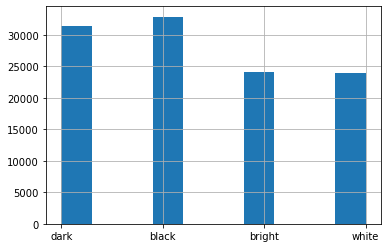

In [25]:
#Посмотрим на полученный результат
data.color.hist()

На выходе мы сократили количество цветов до 4. Тёмных цветов(c учётом чёрного) , как и ожидалось, больше.

### Mileage

Пробег автомобиля

count    1.122150e+05
mean     1.611587e+05
std      1.040403e+05
min      1.000000e+00
25%      8.600000e+04
50%      1.470000e+05
75%      2.170000e+05
max      1.190000e+06
Name: mileage, dtype: float64

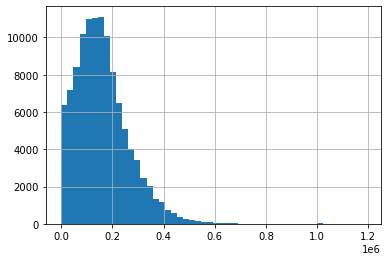

In [26]:
data.mileage.hist(bins = 50)
data.mileage.describe()

У распределения имеется отчётливо выраженный правый хвост. Посмотрим что из себя представляют автомобили с большим пробегом

In [27]:
data[data['mileage']>600000]

,color,car_price,mileage,productionDate,brand,model_name,bodyType,engineDisplacement,enginePower,fuelType,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,sample
1674,bright,250000,680000,2000,Skoda,octavia,лифтбек,1.8,125,Бензин,1.105911e+09,механическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,1
2462,white,680000,635000,2014,Skoda,octavia,лифтбек,1.4,150,Бензин,1.105094e+09,роботизированная,2владельца,Оригинал,передний,Левый,Не требует ремонта,1
2661,dark,210000,776000,2001,Skoda,octavia,универсал 5 дв.,2,115,Бензин,1.080909e+09,механическая,3 или более,Дубликат,передний,Левый,Не требует ремонта,1
4665,white,230000,736000,1995,Audi,a6,универсал 5 дв.,2.6,150,Бензин,1.105827e+09,механическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,1
4887,bright,360000,622000,2003,Audi,a4,седан,1.8,150,Бензин,1.105960e+09,механическая,3 или более,Дубликат,полный,Левый,Не требует ремонта,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28855,white,0,999999,2006,MITSUBISHI,LANCER,седан,1.6 LTR,98 N12,бензин,1.097730e+09,механическая,3 или более,Дубликат,передний,Левый,Не требует ремонта,0
31811,black,0,698000,1996,MERCEDES,S_KLASSE,седан,5.0 LTR,320 N12,бензин,1.101111e+09,автоматическая,3 или более,Дубликат,задний,Левый,Не требует ремонта,0
33535,dark,0,620000,1995,TOYOTA,LAND_CRUISER,внедорожник 5 дв.,4.2 LTR,170 N12,дизель,1.101333e+09,механическая,3 или более,Оригинал,полный,Левый,Не требует ремонта,0
34017,black,0,800000,1989,VOLKSWAGEN,PASSAT,универсал 5 дв.,1.6 LTR,72 N12,бензин,1.101220e+09,механическая,3 или более,Дубликат,передний,Левый,Не требует ремонта,0


In [28]:
#Уберём выбросы
get_quantile(data, 'mileage')


Количество выбросов: mileage : 2424
Верхняя граница выбросов: 413500.0 Нижняя граница выбросов: -110500.0


Верхняя граница выбросов находится на отметке в 413500км, для некоторых моделей автомобилей большие пробеги в порядке вещей. Но это скорее исключение, для большинства автомобилей пробег в 400000 км - достаточно экстремально. К тому же мы не можем исключить вероятность того, что пробег указан неверно (например 999999км). Поэтому заменим выбросы граничным значением

### productionDate

Год производства автомобиля. Для наглядности заменим его на возраст автомобиля

In [29]:
data['car_age'] = data['productionDate'].apply(lambda s: year - s)

In [30]:
#Помортим на результат
data.car_age.describe()

count    112215.000000
mean         11.006211
std           7.477728
min           0.000000
25%           6.000000
50%           9.000000
75%          14.000000
max         117.000000
Name: car_age, dtype: float64

Автомобиль возрастом 117 лет? Взглянем на него поближе.

In [31]:
data[data['car_age']==data['car_age'].max()]

,color,car_price,mileage,productionDate,brand,model_name,bodyType,engineDisplacement,enginePower,fuelType,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,sample,car_age
16944,white,0,48000.0,1904,MERCEDES,SIMPLEX,кабриолет,5.3 LTR,32 N12,бензин,1.093802e+09,механическая,1 владелец,Оригинал,задний,Правый,Не требует ремонта,0,117


И тут мы столкнёмся с проблемой нелинейности цены в зависимости от возраста автомобиля. Автомобили, выпущенные между 1970 и 1990 уже считаются янгтаймерами, машины старше 1970 года выпуска - олдтаймеры. И при хорошем состоянии, цена автомобиля только растёт. Создадим бинарный признак, границу для отделения старых автомобилей, установим на отметке 1985 года

In [32]:
data['car_class'] = data['productionDate'].apply(lambda s: get_class(s))

In [33]:
# Посмотрим на результат
data.car_class.value_counts()

used        111763
oldtimer       452
Name: car_class, dtype: int64

In [34]:
#Удалим колонку productionDate
data.drop(['productionDate'], axis=1, inplace=True)

### Brand

Наименование автопроизводителя

In [35]:
data.brand.value_counts()

BMW              13134
Toyota           11049
Volkswagen        9895
Nissan            9233
Mercedes-Benz     8951
Mitsubishi        6838
Audi              6692
Skoda             6598
VOLKSWAGEN        4404
NISSAN            4393
MERCEDES          4180
TOYOTA            3913
AUDI              3421
Honda             3207
MITSUBISHI        2843
SKODA             2741
Lexus             2661
Volvo             2367
VOLVO             1463
Infiniti          1377
HONDA             1150
INFINITI           871
LEXUS              834
Name: brand, dtype: int64

Позиции дублируются, это связано с тем, что в тестовой и обучающей выборках наименования автомобилей записаны в разном формате. Приведём их к общему виду. За исключением Mercedes-Benz, можно обойтись изменением регистра

In [36]:
data['brand'] = data['brand'].apply(lambda s: 'mercedes' if s=='Mercedes-Benz' else s.lower())

In [37]:
#Посмотрим на полученный результат
data.brand.value_counts()

toyota        14962
volkswagen    14299
nissan        13626
bmw           13134
mercedes      13131
audi          10113
mitsubishi     9681
skoda          9339
honda          4357
volvo          3830
lexus          3495
infiniti       2248
Name: brand, dtype: int64

На выходе мы получили категориальный признак 12 уникальных значений

### model_name

Название модели автомобиля

In [38]:
sorted(train.model_name.unique())

['02',
 '100',
 '1200',
 '164',
 '180sx',
 '190',
 '190_SL',
 '1ER',
 '1m',
 '200',
 '200sx',
 '240_series',
 '240sx',
 '3000',
 '300zx',
 '321',
 '340',
 '350z',
 '370z',
 '440',
 '460',
 '480',
 '4runner',
 '502',
 '740',
 '760',
 '80',
 '850',
 '90',
 '920',
 '940',
 '960',
 'ALMERA_CLASSIC',
 'ALMERA_TINO',
 'A_KLASSE',
 'Allroad',
 'BLUEBIRD_SYLPHY',
 'B_KLASSE',
 'CAMRY_SOLARA',
 'CARINA_E',
 'CARINA_ED',
 'CLA_KLASSE',
 'CLC_KLASSE',
 'CLK_KLASSE',
 'CLS_KLASSE',
 'CL_KLASSE',
 'COROLLA_II',
 'COROLLA_LEVIN',
 'COROLLA_RUMION',
 'COROLLA_SPACIO',
 'COROLLA_VERSO',
 'CROWN_MAJESTA',
 'CR_V',
 'CR_X',
 'CR_Z',
 'C_HR',
 'C_KLASSE',
 'Civic_Ferio',
 'Civic_Type_R',
 'DAYZ_ROOX',
 'DELICA_D2',
 'DELICA_D_5',
 'ECLIPSE_CROSS',
 'EK_WAGON',
 'E_KLASSE',
 'E_TRON',
 'FAIRLADY_Z',
 'FJ_CRUISER',
 'FR_V',
 'GLA_CLASS',
 'GLB_KLASSE',
 'GLE_KLASSE',
 'GLE_KLASSE_COUPE',
 'GLK_KLASSE',
 'GLS_KLASSE',
 'GL_KLASSE',
 'GOLF_GTI',
 'GOLF_PLUS',
 'GOLF_R',
 'GOLF_R32',
 'GRAND_HIACE',
 'GT_R',


In [39]:
#приведём данные к одному виду
data['model_name'] = data['model_name'].apply(lambda s: str(s).lower())

In [40]:
data.model_name.value_counts()

1er                5031
octavia            4374
polo               3262
camry              2668
e_klasse           2458
                   ... 
yaris_verso           1
sai                   1
180sx                 1
eterna                1
master_ace_surf       1
Name: model_name, Length: 626, dtype: int64

Категориальный признак 626 значений

### bodyType

Тип кузова

In [41]:
data.bodyType.value_counts()

внедорожник 5 дв.          42162
седан                      39934
лифтбек                     7699
хэтчбек 5 дв.               6874
универсал 5 дв.             3964
минивэн                     3258
купе                        2347
компактвэн                  1832
хэтчбек 3 дв.               1229
пикап двойная кабина        1036
купе-хардтоп                 419
внедорожник 3 дв.            377
фургон                       322
кабриолет                    279
родстер                      270
седан-хардтоп                 88
микровэн                      44
седан 2 дв.                   23
пикап одинарная кабина        21
пикап полуторная кабина       16
лимузин                       11
внедорожник открытый           5
тарга                          4
фастбек                        1
Name: bodyType, dtype: int64

Сократим количество признаков

In [42]:
data['bodyType'] = data['bodyType'].apply(lambda s: str(s).split(' ')[0])
#группируем типы кузова
data['bodyType'] = data['bodyType'].apply(lambda s: get_types(s))

In [43]:
data.bodyType.value_counts()

suv        42544
sedan      40045
hatch      15802
van         5134
family      3964
gt          3320
truck       1395
premium       11
Name: bodyType, dtype: int64

На выходе мы получили 7 уникальных значений

### engineDisplacement

Объём двигателя

In [44]:
data.engineDisplacement.value_counts()

2.0        16330
3.0         8000
2.0 LTR     7391
1.6         7252
1.6 LTR     4973
           ...  
3.9 LTR        1
6.8            1
6.3            1
5.3 LTR        1
5.8            1
Name: engineDisplacement, Length: 160, dtype: int64

Необходимо убрать LTR

In [45]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda s: str(s).replace(' LTR', ''))

In [46]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda s: str(s).replace('', 'EV'))

In [47]:
data[data['engineDisplacement']=='EV']

,color,car_price,mileage,brand,model_name,bodyType,engineDisplacement,enginePower,fuelType,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,sample,car_age,car_class
77468,dark,2950000,19000.0,bmw,i3,hatch,EV,184,электро,1.106052e+09,автоматическая,2владельца,Оригинал,задний,Левый,Не требует ремонта,1,3,used
77469,white,2260000,20000.0,bmw,i3,hatch,EV,184,электро,1.106013e+09,автоматическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,1,3,used
77472,dark,3110000,27000.0,bmw,i3,hatch,EV,184,электро,1.106051e+09,автоматическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,1,2,used
77474,white,1680000,82000.0,bmw,i3,hatch,EV,184,электро,1.105018e+09,автоматическая,1владелец,Оригинал,задний,Левый,Не требует ремонта,1,7,used
77475,dark,1540000,71000.0,bmw,i3,hatch,EV,184,электро,1.106021e+09,автоматическая,1владелец,Оригинал,задний,Левый,Не требует ремонта,1,7,used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32668,black,0,100.0,nissan,leaf,hatch,EV,150 N12,электро,1.101206e+09,автоматическая,1 владелец,Оригинал,передний,Левый,Не требует ремонта,0,3,used
32700,bright,0,29500.0,nissan,leaf,hatch,EV,109 N12,электро,1.101341e+09,автоматическая,1 владелец,Оригинал,передний,Правый,Не требует ремонта,0,10,used
32798,black,0,50000.0,nissan,leaf,hatch,EV,109 N12,электро,1.091614e+09,автоматическая,1 владелец,Оригинал,передний,Правый,Не требует ремонта,0,8,used
34159,white,0,28900.0,mercedes,b_klasse,hatch,EV,179 N12,электро,1.101371e+09,автоматическая,2 владельца,Оригинал,передний,Левый,Не требует ремонта,0,5,used


В этом признаке нулевые значения, что логично, принадлежат электромобилям. Более универсальной характеристикой двигателя является его мощность. Потому на данный момент от объёма двигателя можно отказаться.

In [48]:
data.drop(['engineDisplacement'], axis=1, inplace=True)

### EnginePower

Мощность двигателя

In [49]:
data.enginePower.value_counts()

150        5427
110        2529
105        2454
190        2006
140        1950
           ... 
321 N12       1
42 N12        1
431 N12       1
261           1
34            1
Name: enginePower, Length: 673, dtype: int64

In [50]:
# Уберём N12
data['enginePower'] = data['enginePower'].apply(lambda s: str(s).replace(' N12', ''))

In [51]:
#Переведём обратно в integer
data['enginePower'] = data['enginePower'].apply(lambda s: int(s))

<AxesSubplot:>

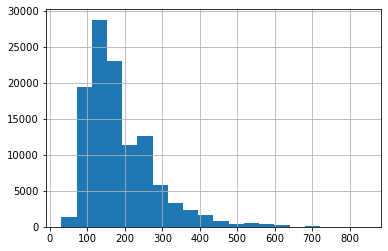

In [52]:
#Посмтрим на распределение полученных данных
data.enginePower.hist(bins=20)

In [53]:
#get_quantile(data, 'enginePower')

Распределение имеет правый хвост, большой мощностью обладают дорогие люксовые автомобили. Пока оставим как есть, при необходимости стандартизируем

In [54]:
#Посмотрим на мощные автомобили
#data.query('enginePower>400 & car_age>5')

### fuelType

Тип топлива

In [55]:
data.fuelType.value_counts()

 Бензин                                50040
бензин                                 28601
 Дизель                                23274
дизель                                  5800
 Гибрид                                 2800
 Бензин, газобаллонное оборудование      900
гибрид                                   223
 Дизель, газобаллонное оборудование      220
 Газ                                     211
электро                                  116
 Гибрид, газобаллонное оборудование       19
газ                                        7
 Газ, газобаллонное оборудование           4
Name: fuelType, dtype: int64

In [56]:
#Приведём к единому регистру
data['fuelType'] = data['fuelType'].apply(lambda s: str(s).lower())
data['fuelType'] = data['fuelType'].apply(lambda s: str(s).replace(' ', ''))

In [57]:
data['fuelType'] = data['fuelType'].apply(lambda s: fuel_type(str(s).split(',')))

In [58]:
#Результат
data.fuelType.value_counts()

бензин     79541
дизель     29294
гибрид      3042
газ          222
электро      116
Name: fuelType, dtype: int64

На выходе мы получили категориальный признак. 5 уникальных значений.

### vehicleTransmission

In [59]:
data.vehicleTransmission.value_counts()

автоматическая      55715
механическая        33926
вариатор            11786
роботизированная    10788
Name: vehicleTransmission, dtype: int64

### ПТС

In [60]:
data['ПТС'].value_counts()

Оригинал    94361
Дубликат    17853
Name: ПТС, dtype: int64

In [61]:
# Создадим бинарный признак
data['pts'] = data['ПТС'].apply(lambda s: 1 if s=='Оригинал' else 0)

In [62]:
#И удалим ненужный признак
data.drop(['ПТС'], axis=1, inplace=True)


### Привод

тип привода

In [63]:
data['Привод'].value_counts()

передний    50348
полный      47771
задний      14096
Name: Привод, dtype: int64

In [64]:
data['drivetrain'] = data['Привод']
data.drop(['Привод'], axis=1, inplace=True)

### Руль

Расположение водителя в автомобиле

In [65]:
data['Руль'].value_counts()

Левый     104768
Правый      7447
Name: Руль, dtype: int64

In [66]:
# Создадим бинарный признак
data['steering_wheel'] = data['Руль'].apply(lambda s: 1 if s=='Левый' else 0)

В нашем датасете большинство автомобилей с левым расположением руля

In [67]:

data.drop(['Руль'], axis=1, inplace=True)

### Состояние

In [68]:
data['Состояние'].value_counts()

Не требует ремонта    110861
Битый / не на ходу      1354
Name: Состояние, dtype: int64

У нас два варианта состояния автомобиля

In [69]:
data['conditions'] = data['Состояние'].apply(lambda s: 1 if s=='Не требует ремонта' else 0)
data.drop(['Состояние'], axis=1, inplace=True)

### Владельцы

Количество владельцев. Небольшое количество владельцев у автомобиля либо говорит нам о том, что автомобиль достаточно новый, либо автомобиль долго находился у одного владельца (обычно такие автомобили в хорошем состоянии, что положительно сказывается на цене)

In [70]:
data['Владельцы'].value_counts()

3 или более    53219
1владелец      22231
2владельца     18036
1 владелец      9459
2 владельца     9270
Name: Владельцы, dtype: int64

In [71]:
#Переименуем
#Приведём к одному виду, убрав пробелы
data['owners'] = data['Владельцы'].apply(lambda s: str(s)[0])

In [72]:
data.drop(['Владельцы'], inplace=True, axis=1)

In [73]:
data.owners.value_counts()

3    53219
1    31690
2    27306
Name: owners, dtype: int64

### Rating

Создадим параметр рейтинг надёжности. Данные основаны на исследовании удовлетворённости клиентов, проведённом американской компанией J.D.Power and Associates. Данный рейтинг показывает среднее количество дефектов, приходящихся на 100 автомобилей бренда 

In [74]:
#Для начала скопируем столбец brand
data['rating'] = data['brand']

In [75]:
#И заменим название бренда на его рейтинг
data['rating'] = data['rating'].replace(to_replace = rating_list)

In [76]:
#Среднее значение по рынку
average = 122
#Разделим на выше среднего и ниже
data['rating'] = data['rating'].apply(lambda s: 'low' if s > average else 'high')

In [77]:
data.rating.value_counts()

low     57812
high    54403
Name: rating, dtype: int64

На выходе мы получили бинарный признак.

### Expences

Расходы на содержание. Данные основаны на исследовании компании YourMechanic. Данные представляют из себя среднюю сумму расходов на обслуживание в год.

In [78]:
#Для начала скопируем столбец brand
data['expences'] = data['brand']

In [79]:
#И заменим название бренда на стоимость обслуживания
data['expences'] = data['expences'].replace(to_replace = car_expences_list)

In [80]:
data.expences.value_counts()

56160     23638
39600     14962
54720     13626
106800    13134
77400     13131
74400     10113
53280      9681
51840      4357
75000      3830
50400      3495
55800      2248
Name: expences, dtype: int64

### Car_price 

Наш ключевой признак, обозначающий цену автомобиля

![car_price.jpg](car_price.jpg)

В результате несложных подсчётов, к октябрю 2021 года средняя цена на подержанные автомобили выросла на 24%. Графика с auto.ru

In [81]:
#Коэффициент для изменения цены
koef = 0.76
#Подгоним цену, насколько это возможно, к октябрю 2020 года
#
data['car_price'] = data['car_price'].apply(lambda s: round(koef*s, -3))

Обычно цену на автомобили назначают кратно 1000, округлим цену

In [82]:
#Ещё раз посмотрим на данные
data.head(5)

,color,car_price,mileage,brand,model_name,bodyType,enginePower,fuelType,sell_id,vehicleTransmission,sample,car_age,car_class,pts,drivetrain,steering_wheel,conditions,owners,rating,expences
0,dark,1398000.0,30000.0,skoda,octavia,hatch,184,дизель,1.105830e+09,роботизированная,1,3,used,1,полный,1,1,1,low,56160
1,black,1246000.0,80000.0,skoda,superb,hatch,190,дизель,1.103512e+09,роботизированная,1,4,used,1,полный,1,1,1,low,56160
2,bright,243000.0,168000.0,skoda,octavia,hatch,115,бензин,1.105757e+09,механическая,1,16,used,1,передний,1,1,3,low,56160
3,dark,608000.0,170000.0,skoda,octavia,hatch,105,дизель,1.105957e+09,роботизированная,1,9,used,1,передний,1,1,2,low,56160
4,dark,1193000.0,5000.0,skoda,rapid,hatch,110,бензин,1.105881e+09,автоматическая,1,1,used,1,передний,1,1,1,low,56160


In [83]:
#Удалим колонку sell_id (id-номер объявления)
data.drop(['sell_id'], axis=1, inplace=True)

In [84]:
#бинарные переменные
bin_cols=['pts','steering_wheel','conditions', 'rating', 'car_class']

#категориальные переменные
cat_cols=['color', 'brand','bodyType','fuelType', 'vehicleTransmission',
         'drivetrain', 'owners']

#числовые переменные
num_cols=['car_age', 'enginePower', 'mileage', 'expences']

#целевая переменная
target_cols = ['car_price']

### Корреляционный анализ для числовых пременных

<AxesSubplot:>

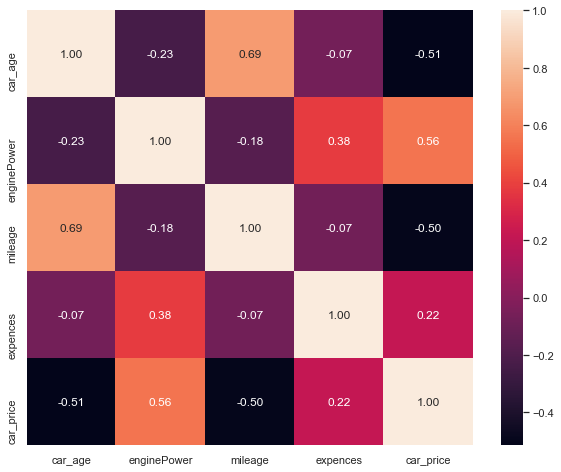

In [85]:
sns.set(font_scale=1)
plt.subplots(figsize=(10,8))
sns.heatmap(data.query('sample==1')[num_cols+target_cols].corr(), annot=True, fmt='.2f')

Между возрастом и пробегом автомобиля имеется корреляция, но не критичная. 

In [86]:
box_data = data[data['sample']==1]

pts


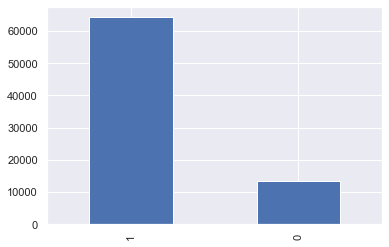

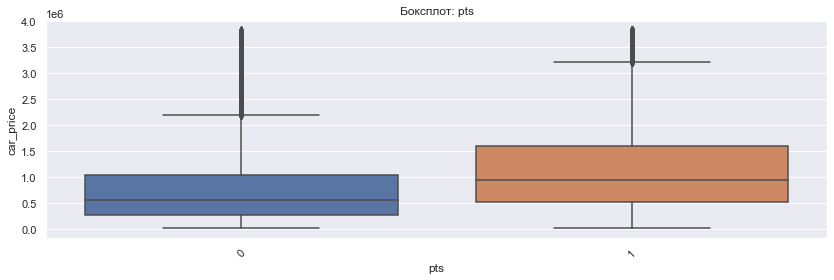

steering_wheel


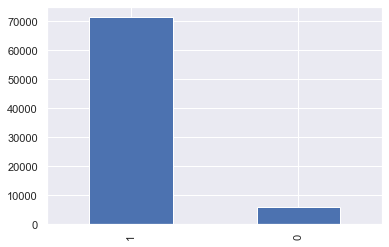

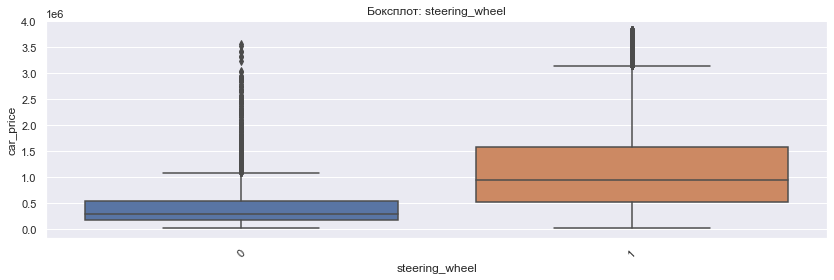

conditions


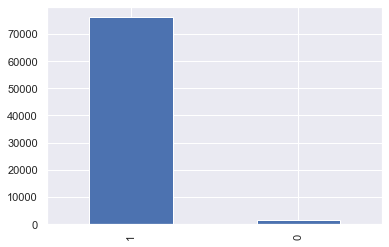

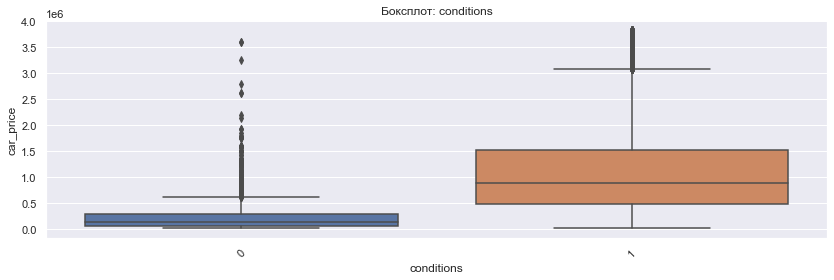

rating


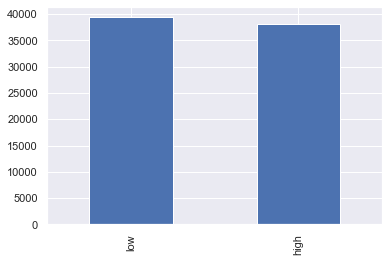

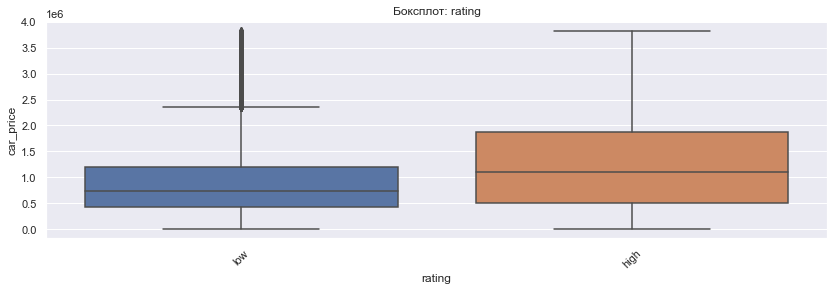

car_class


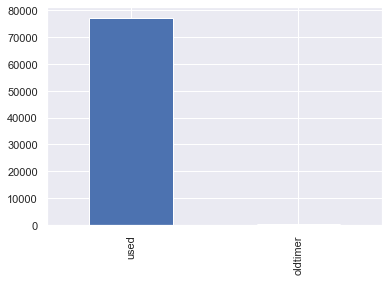

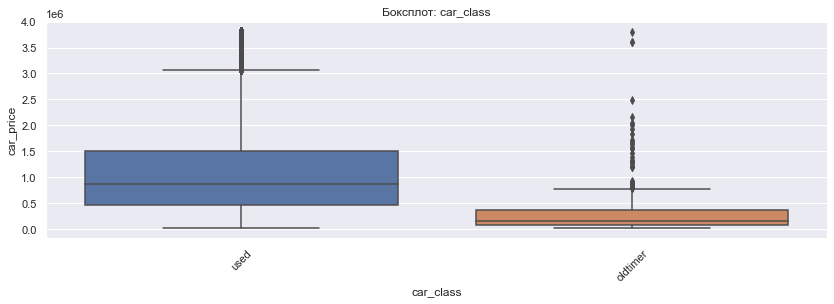

color


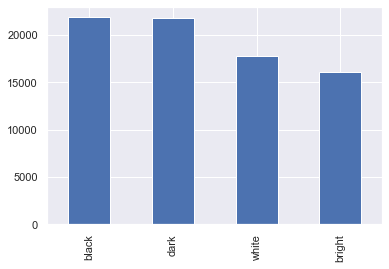

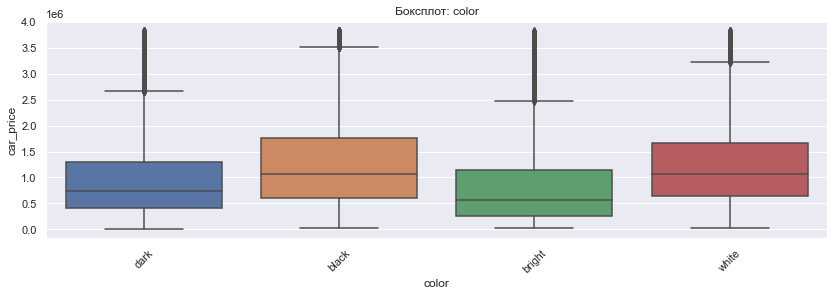

brand


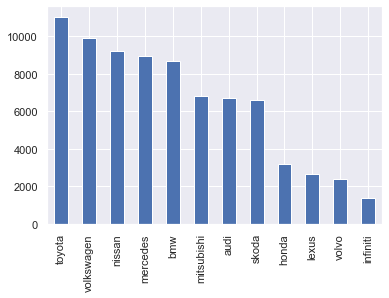

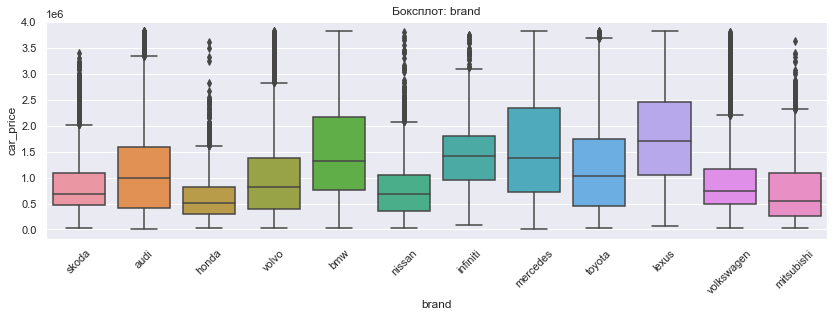

bodyType


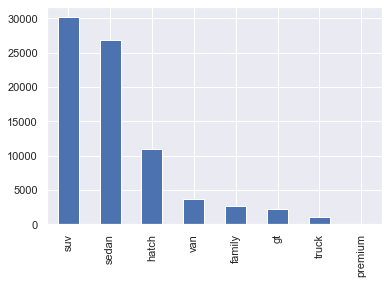

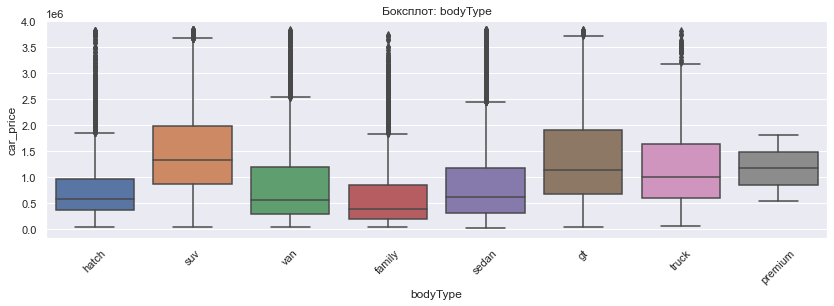

fuelType


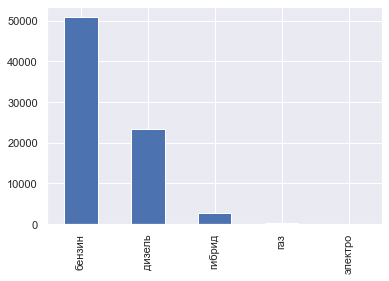

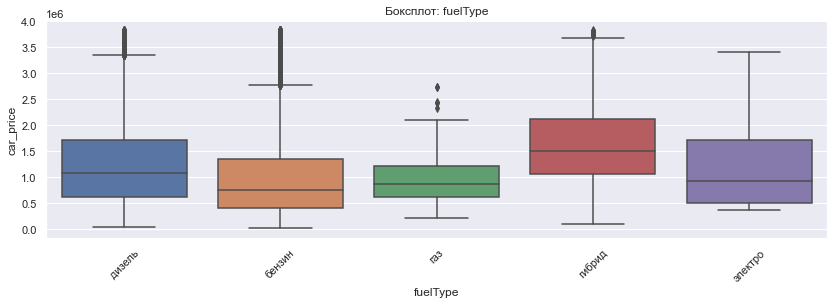

vehicleTransmission


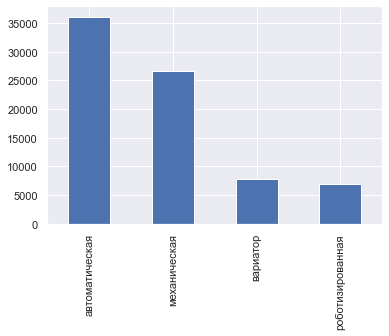

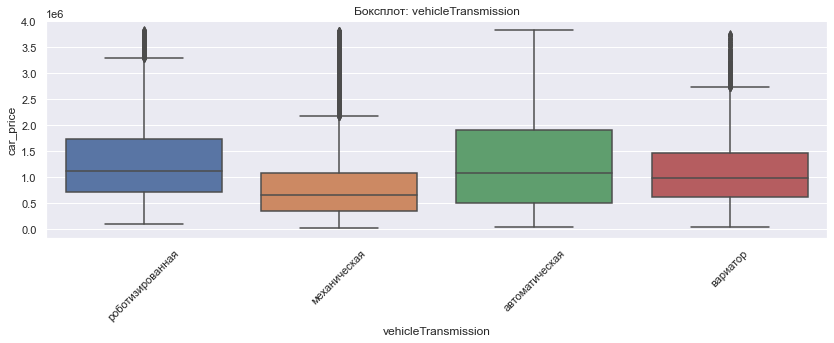

drivetrain


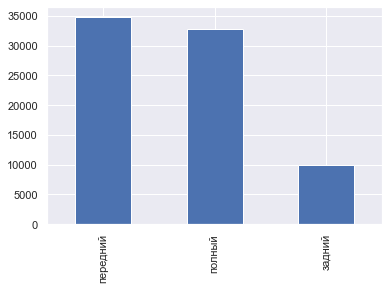

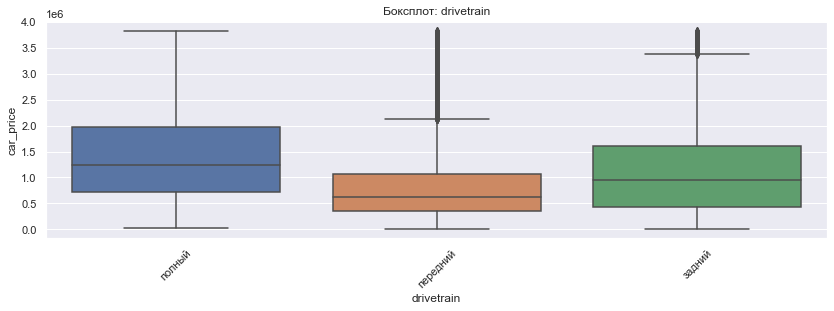

owners


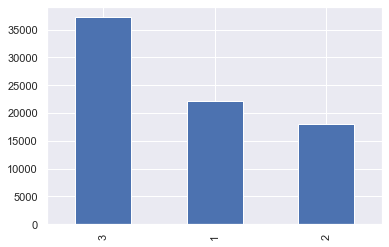

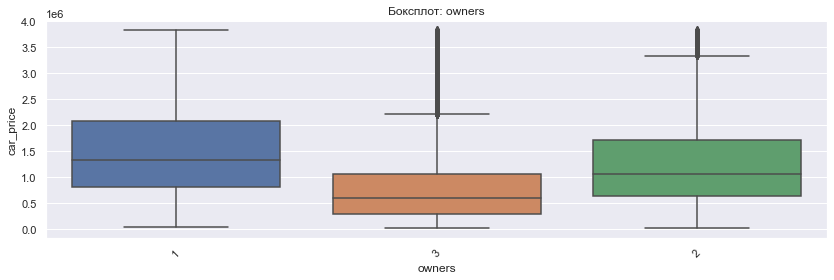

In [87]:
for col in bin_cols + cat_cols:
    if col not in ['model_name']:
        print(col)
        box_data[col].value_counts().plot(kind='bar')
        get_boxplot(data = box_data[box_data.car_price <= box_data.car_price.quantile(0.95)],
                    column=col,
                    target_column='car_price')

На что стоит обратить внимание:

- pts: дубликат птс(значение 0) говорит о том, что либо документы были утеряны, либо у автомобиля проводилось достаточно много регистрационных действий
- steering_wheel: автомобилей с левым рулём больше. Всвязи с повышением ввозных пошлин, импорт праворульных автомобилей заметно сократился.
- conditions: в нашей выборке битых автомобилей совсем мало, но они есть. Автомобили, требующие ремонта стоят дешевле
- brand: производители дорогих автомобилей заметно выделяются
- drivetrain: переднеприводных автомобилей больше, но зачастую это предствители масс-маркета и минимальных комплектаций, что непосредственно сказывается на цене
- color: Чёрный цвет самый популярный, что сказывается на цене
- bodytype Внедорожники и спортивные автомобили (класс gt) ценятся выше других типов кузова
- автомобили с высоким рейтингом надёжности ценятся на вторичном рынке

Каждый из имеющихся признаков, судя по графике, оказывает влияние на ценобразование

## Обработка категориальных переменных

In [88]:
data.model_name.nunique()

626

626 уникальных значений названий автомобилей. И в пределах одного бренда разные модели имеют свой набор параметров, влияющих на цену. Если использовать OneHot мы создадим соответственно 626 признаков. Будем использовать двоичное кодирование. Это поможет нам сократить количество признаков.

In [89]:
#Кодируем бинарные признаки
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

<AxesSubplot:>

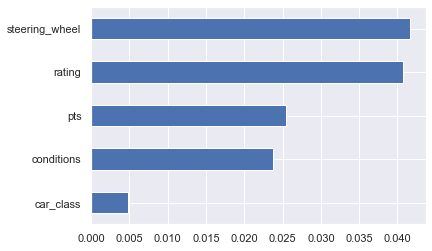

In [90]:
imp_cat = Series(mutual_info_classif(data[bin_cols],
                                     data['car_price'], discrete_features =True),
                                     index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [91]:
#Создадим копию датасета
df = data.copy()

Для кодировки названия автомобилей, будем использовать BinaryEncoders. Он представляет значения признака в виде двоичного кода

In [92]:
encoder = ce.BinaryEncoder(cols=['model_name'])
df_bin = encoder.fit_transform(df['model_name'])
df = pd.concat([df, df_bin], axis = 1)
df

,color,car_price,mileage,brand,model_name,bodyType,enginePower,fuelType,vehicleTransmission,sample,...,model_name_0,model_name_1,model_name_2,model_name_3,model_name_4,model_name_5,model_name_6,model_name_7,model_name_8,model_name_9
0,dark,1398000.0,30000.0,skoda,octavia,hatch,184,дизель,роботизированная,1,...,0,0,0,0,0,0,0,0,0,1
1,black,1246000.0,80000.0,skoda,superb,hatch,190,дизель,роботизированная,1,...,0,0,0,0,0,0,0,0,1,0
2,bright,243000.0,168000.0,skoda,octavia,hatch,115,бензин,механическая,1,...,0,0,0,0,0,0,0,0,0,1
3,dark,608000.0,170000.0,skoda,octavia,hatch,105,дизель,роботизированная,1,...,0,0,0,0,0,0,0,0,0,1
4,dark,1193000.0,5000.0,skoda,rapid,hatch,110,бензин,автоматическая,1,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,dark,0.0,115000.0,bmw,3er,sedan,136,бензин,автоматическая,0,...,1,0,0,0,1,0,1,1,1,0
34682,black,0.0,98000.0,bmw,5er,sedan,190,дизель,автоматическая,0,...,1,0,0,0,1,0,1,0,1,0
34683,dark,0.0,360000.0,bmw,5er,sedan,170,бензин,автоматическая,0,...,1,0,0,0,1,0,1,0,1,0
34684,dark,0.0,90500.0,bmw,x1,suv,184,дизель,автоматическая,0,...,0,0,1,0,0,0,0,1,0,1


In [93]:
# Удалим наименование модели
df.drop(['model_name'], axis=1, inplace=True)


In [94]:
#Создадим dummy-переменные для остальных признаков
df = pd.get_dummies(df, columns=cat_cols)

In [95]:
scaler = MinMaxScaler()
for col in ['enginePower', 'car_age', 'expences', 'mileage']:
    income_std = scaler.fit_transform(df.loc[:,[col]])
    df[col] = income_std

In [96]:
#Проверим результат
display(df.head(3))


,car_price,mileage,enginePower,sample,car_age,car_class,pts,steering_wheel,conditions,rating,...,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,drivetrain_задний,drivetrain_передний,drivetrain_полный,owners_1,owners_2,owners_3
0,1398000.0,0.072549,0.189422,1,0.025641,1,1,1,1,1,...,0,0,0,1,0,0,1,1,0,0
1,1246000.0,0.193468,0.196802,1,0.034188,1,1,1,1,1,...,0,0,0,1,0,0,1,1,0,0
2,243000.0,0.406286,0.104551,1,0.136752,1,1,1,1,1,...,0,0,1,0,0,1,0,0,0,1


In [97]:
#Отделим тренировочную выборку
df_train = df[df['sample'] == 1]
df_train.drop(['sample'], axis=1, inplace=True)

In [98]:
df_train['car_price'] = df_train['car_price'].apply(lambda s: np.log(s))

In [99]:
#cols = df_train.columns

### Модель 2: RandomForest



In [100]:
X = df_train.drop(['car_price'], axis = 1)
Y = df_train['car_price'].values

In [101]:
#Разделим данные для обучения
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=VAL_SIZE, random_state=RANDOM_SEED, shuffle = True)

In [102]:
rtr = RandomForestRegressor(n_estimators=300, n_jobs=2, random_state=RANDOM_SEED)

In [103]:
rtr.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=300, n_jobs=2, random_state=42)

In [104]:
predict = rtr.predict(X_test)

In [105]:
print(f"Точность модели по метрике MAPE: {(mape(np.exp(Y_test), np.exp(predict))):0.2f}%")

Точность модели по метрике MAPE: 15.80%


In [106]:
X_test

,mileage,enginePower,car_age,car_class,pts,steering_wheel,conditions,rating,expences,model_name_0,...,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,drivetrain_задний,drivetrain_передний,drivetrain_полный,owners_1,owners_2,owners_3
5981,0.372429,0.166052,0.179487,1,0,1,1,1,0.517857,0,...,1,0,0,0,0,1,0,0,0,1
75481,0.026600,0.172202,0.042735,1,1,1,1,1,0.246429,0,...,1,0,0,0,0,1,0,1,0,0
69693,0.340990,0.138991,0.068376,1,1,1,1,0,1.000000,0,...,0,0,1,0,1,0,0,0,0,1
10089,0.188632,0.280443,0.034188,1,1,1,1,0,1.000000,0,...,1,0,0,0,0,0,1,0,1,0
66975,0.447399,0.222632,0.102564,1,1,1,1,1,0.517857,0,...,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30878,0.319224,0.269373,0.025641,1,1,1,1,1,0.517857,0,...,1,0,0,0,0,0,1,1,0,0
75755,0.490930,0.088561,0.102564,1,1,1,1,1,0.246429,0,...,1,0,0,0,0,1,0,0,1,0
1043,0.643288,0.172202,0.119658,1,1,1,1,1,0.246429,0,...,0,0,1,0,0,1,0,0,0,1
73643,0.333735,0.073801,0.059829,1,1,1,1,0,0.000000,0,...,0,0,1,0,0,1,0,0,0,1


### Модель 3: ExtraTrees

В данном классе реализован метаоценщик, использует усреднение для повышения точности прогнозирования

In [ ]:
xtr = ExtraTreesRegressor(n_estimators=300,
                         criterion='mse',
                         n_jobs=4,
                         warm_start=True,
                         random_state=RANDOM_SEED)

In [ ]:
xtr.fit(X_train, Y_train)

In [ ]:
xtr_predict = xtr.predict(X_test)

In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(np.exp(Y_test), np.exp(xtr_predict))):0.2f}%")

### Модель 4: CatBoost
Модель, которая хорошо себя чувствует с категориальными признаками, которых у нас в достатке

In [ ]:
cat = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True)


In [ ]:
cat.fit(X_train, Y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, Y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

In [ ]:
# оцениваем точность
predict = cat.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(np.exp(Y_test), np.exp(predict))):0.2f}%")

### Модель 5: DecisionTree

In [ ]:
dtr = DecisionTreeRegressor(criterion = 'mse',
                           random_state = RANDOM_SEED)

In [ ]:
dtr.fit(X_train, Y_train)

In [ ]:
dtr_predict = dtr.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(np.exp(Y_test), np.exp(dtr_predict))):0.2f}%")

## Стекинг

In [ ]:
estimators = [
    ('rtr', RandomForestRegressor(n_estimators=150,
                                  n_jobs=4,
                                  warm_start=True,
                                  random_state=RANDOM_SEED)),
    ('xtr',  ExtraTreesRegressor(n_estimators=150,
                         criterion='mse',
                         n_jobs=4,
                         warm_start=True,
                         random_state=RANDOM_SEED))]

ste = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(n_jobs=4))

In [ ]:
ste.fit(X_train, Y_train)

In [ ]:
ste_predict = ste.predict(X_test)

In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(np.exp(Y_test), np.exp(ste_predict))):0.2f}%")